In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_00_load_data")' FastaiNotebook_00_load_data

Installing packages:
	.package(path: "/home/ubuntu/git/fastai_docs/dev_swift/FastaiNotebook_00_load_data")
		FastaiNotebook_00_load_data
With SwiftPM flags: []
Working in: /tmp/tmpilmqtxg_/swift-install
/home/ubuntu/swift/usr/bin/swift-build: /home/ubuntu/anaconda3/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/lib/swift/linux/libFoundation.so)
/home/ubuntu/swift/usr/bin/swift-build: /home/ubuntu/anaconda3/lib/libcurl.so.4: no version information available (required by /home/ubuntu/swift/usr/lib/swift/linux/libFoundation.so)
/home/ubuntu/swift/usr/bin/swiftc: /home/ubuntu/anaconda3/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swiftc)
Compile Swift Module 'FastaiNotebook_00_load_data' (1 sources)
/home/ubuntu/swift/usr/bin/swiftc: /home/ubuntu/anaconda3/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swiftc)

/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anac

In [ ]:
//export
import Path

In [ ]:
import FastaiNotebook_00_load_data

# Hello Swift

The first thing you'll notice about Swift is that it has variables (`var`) and constants (`let`).  Swift also has types.

In [ ]:
// These are integers
let batchSize = 6
var b = 1 + (4 * batchSize)
print("some integers:", b)

// These are floating point values.
var myPi = 3.1
var π    = Float.pi
print("some floats: ", myPi, π)

some integers: 25
some floats:  3.1 3.1415925


Constants cannot be changed after they are set:

In [ ]:
batchSize = 8

: 

Swift has types and type inference.  This means you often don't have to specify the types, but they are there, and can be used to override type inference:


In [ ]:
// Type inference would produce an integer, but we make this be a float.
var someFloat : Float = 1 + 4*9

// Jeremy might not like greek letters, but he surely loves emoji 😬
var 🐶💩 = "dog poo"
print(🐶💩)


// This is the equivalent of the Python 'type' operator.
print("some types: ", type(of: someFloat), type(of: 🐶💩))

dog poo
some types:  Float String


### Functions, tuples, and structs in Swift 

Functions are declare with `func` instead of `def` in Swift.  They include types, and default to having argument labels.

In [ ]:
func distance(x: Float, y: Float) -> Float {
    return sqrt(x*x+y*y)
}

// Functions default to having argument labels:
print(distance(x: 1.0, y: 2.0))


2.236068


Sometimes argument labels are the wrong thing, and sometimes you want the caller to use a different argument label than you want to use as the name inside of a function.  To support this, Swift allows you to use two names for each argument, and the underscore means "ignore".

Swift also has tuples just like Python, and you can use them to return multiple results:

In [ ]:
func sincos(_ value: Float) -> (Float, Float) {
    return (sin(value), cos(value))
}

// Print the tuple.
print(sincos(2*π))

// Destructuring too.
let (s, c) = sincos(42)

let tupleValue = sincos(213)
print(tupleValue.1)
print(s + c)


(-3.019916e-07, 1.0)
0.8090276
-1.3165069


You can define structures with the struct keyword, which gives you a name for a type.  Structs are super efficient (no memory allocation etc) and allow you to access the fields conveniently:

In [ ]:
struct ComplexF {
    var real, imag : Float
}

var someComplex = ComplexF(real: 1.0, imag: 12.0)
print(someComplex)

ComplexF(real: 1.0, imag: 12.0)


This looks almost identical to a [dataclass](https://docs.python.org/3/library/dataclasses.html) in python:
```python
@dataclass
class ComplexF:
    real:float
    imag:float

someComplex = ComplexF(1.0, 12.0)
someComplex
```

Once you have types, you want to write generic code.  Generics in Swift work very differently than Java or C++ generics, but the syntax is similar:



In [ ]:
struct Complex<T : SignedNumeric> {
    var real, imag : T
    
    // This is a computed property.
    var conj : Complex { return Complex(real: real, imag: -imag) }
    
    // Here's a computed property with a setter, just because we can.
    var i : T {
        get { return imag }
        set { imag = newValue }
    }
    
    // This is a method.
    func add(_ other: Complex) -> Complex {
        return Complex(real: real + other.real,
                       imag: imag + other.imag)
    }
}

var complexInt = Complex(real: 1, imag: 12)
var complexDouble = Complex(real: 1.0, imag: π)
print(complexInt, complexDouble, separator: "\n")
print()

print("Conj:    ", complexInt.conj)
print("Doubled: ", complexDouble.add(complexDouble))


Complex<Int>(real: 1, imag: 12)
Complex<Float>(real: 1.0, imag: 3.1415925)

Conj:     Complex<Int>(real: 1, imag: -12)
Doubled:  Complex<Float>(real: 2.0, imag: 6.283185)


Operators are just a function in Swift, you just define them with `func`.  Swift lets you add methods after defining a type with `extension`:

In [ ]:
extension Complex {
    static func+(lhs : Complex, rhs: Complex) -> Complex {
        return Complex(real: lhs.real + lhs.real, 
                       imag: lhs.imag + rhs.imag)
    }
}

print("added: ", complexInt + complexInt)


// You can even define your own happy cat operator if you feel like it.
// Please don't get too crazy.
prefix operator ^*^
prefix func ^*^(value: Complex<Float>) -> Float {
    return atan2(value.real, value.imag)
}

print("atan2'd: ", ^*^complexDouble)


added:  Complex<Int>(real: 2, imag: 24)
atan2'd:  0.3081691


Okay, that's your basic introduction to Swift.  Now lets talk about ... Python?!

# Swift loves Python too

In [ ]:
//export

// One of the cool things about Swift for TensorFlow is that we can directly call into
// Python.  First we import Python into Swift.
import Python

In [ ]:
//export

// You can import arbitrary Python modules and directly use them.
// No wrappers, interface libraries, code generators, or build steps.
public let np = Python.import("numpy")
public let plt = Python.import("matplotlib.pyplot")

In [ ]:
// Err, 🐍 in Swift??  Yep, it turns out that Swift is super dynamic too, so it can
// directly talk to the Python runtime.  We'll talk about that later.
let npArray = np.array([1,2,3,4])
print("NumPy Array:", npArray)

// Python is a dynamically typed language ... but another way to look at it is 
// that it has exactly one static type.  Swift calls it `PythonObject`.
print("NumPy Module Type: ", type(of: np))
print("NumPy Function Type: ", type(of: np.array))
print("NumPy Array Type: ", type(of: npArray))
print(npArray*2, npArray[1])

NumPy Array: [1 2 3 4]
NumPy Module Type:  PythonObject
NumPy Function Type:  PythonObject
NumPy Array Type:  PythonObject
[2 4 6 8] 2


Why do we want this?  Well it turns out that the entire datascience ecosystem is in Python, and many of you are comfortable with Python APIs.  Swift can do lots of things, but Python is just fine for basic things like reading files, so there's no need to change what isn't broken!


## Back to the tutorial: Let's load the data

In [ ]:
//import Path
import TensorFlow

In [ ]:
// loadMNIST is defined in workbook 00_load_data.
let (xTrain, yTrain, xValid, yValid) = loadMNIST(path: mnistPath, flat: true)

In [ ]:
// That just loaded a TensorFlow Tensor:
print(type(of: xTrain))
print(xTrain.shape, yTrain.shape, xValid.shape, yValid.shape, separator: "\n")


Tensor<Float>
TensorShape(dimensions: [60000, 784])
TensorShape(dimensions: [60000])
TensorShape(dimensions: [10000, 784])
TensorShape(dimensions: [10000])


We'll talk about Tensors more later.

### Using matplotlib

Let's take a look at an example from MNIST.  We'll import matplotlib, just like we imported numpy before:

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


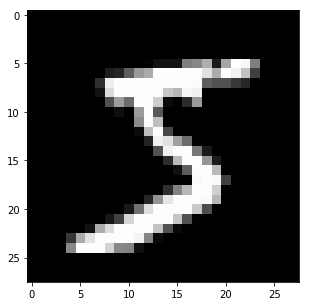

None


In [ ]:
// It's super easy to turn an example from the tensor into a NumPy array.
let img = xTrain[0].makeNumpyArray().reshape(28, 28)

// Then have 
plt.figure(figsize: [5,5])
plt.show(plt.imshow(X: img, cmap: "gray"))

## Working with Tensor

The Tensor type is the primary interface for working with tensor data, and has normal methods that you'd expect.  For example, you can get randomly initialized or zero initialized tensors like this:


In [ ]:
var weights = Tensor<Float>(randomNormal: [784, 10]) / sqrt(784)
var bias = Tensor<Float>(zeros: [10])
print(bias)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Tensor provides all the normal stuff you'd expect, including broadcasting support:



In [ ]:
let small = Tensor<Float>([[1, 2],
                           [3, 4]])

print("2x2:\n",             small)
print("\nmatmul:\n",        matmul(small, small))
print("\nbroadcast add:\n", small + 100)

2x2:
 [[1.0, 2.0],
 [3.0, 4.0]]

matmul:
 [[ 7.0, 10.0],
 [15.0, 22.0]]

broadcast add:
 [[101.0, 102.0],
 [103.0, 104.0]]


You can see all things Tensor can do in the [official documentation](https://www.tensorflow.org/swift/api_docs/Structs/Tensor).

# "Impractical" Programming Languages

We now have a bit of a grasp on how Swift basics work, but we're taking a lot for granted here!  We are supposed to be building an entire machine learning framework from scratch!

Jeremy started by showing you how to implement a MatMul using an array of floating point scalars, "from the foundations". Apparently, Jeremy thinks this is the foundations:

```python
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c
```

Let's do it properly, this time... and we can talk more about what programming languages are, how compilers work, and then we can understand what Swift really is.

  Slides: [What is a Compiler](https://docs.google.com/presentation/d/1dc6o2o-uYGnJeCeyvgsgyk05dBMneArxdICW5vF75oU/edit#slide=id.g5674d3ead7_0_83)


## Building Float

Ok, now we know how to build Float, Double, Int, etc.  One really nice thing is that this generates really great code.

In [ ]:
// Really simple math
func squareAdd(n: Float) -> Float {
    let tmp = n * n
    let result = tmp + 1.0
    return result
}


Check this out on the ["godbolt" compiler explorer](https://godbolt.org/z/Xns8IA)!

In [ ]:
// Really, Int and Float are implemented in the standard library.  You can actually
// see the underlying field if you know where to look:
var someInt = 42
print(type(of: someInt._value))
print(type(of: π._value))


Builtin.Int64
Builtin.FPIEEE32


In [ ]:
// That said you can't do anything useful with it - only the Swift standard library gets 
// to use the Builtin module.  It is a private interface between the standard library and
// the compiler.
import Builtin

: 

A cool thing is that since these things are normal types, you can add your own operators and methods to them, just like you can with any old type:

In [ ]:
extension Int {
  var isOdd : Bool { return self & 1 != 0 }
}

print("Feeling odd?  Lets check 4 and 17:\n", 4.isOdd, 17.isOdd)

Feeling odd?  Lets check 4 and 17:
 false true


Lots of the Swift "language" is implemented in the standard library, including primitive types like `Bool` as well.  Check out how short circuiting `&&` and `||` operators are [implemented right in the standard library](https://github.com/apple/swift/blob/master/stdlib/public/core/Bool.swift#L245).  Even primitives like `assert` are just [functions implemented in Swift](https://github.com/apple/swift/blob/master/stdlib/public/core/Assert.swift#L13).


## Looking inside Array

Of course, `Array` and `String` are also built into the library.  Array in Swift contains a pointer to the elements and a size and a reserved capacity.  Let's try it out to see how it works.


In [ ]:
// Arrays work with type inference:
var myArray = [1,2,3,4,5,6]

// You can write array types with [] syntax, which is what most people do...
var myArray2 : [Int] = myArray

// But this is just synactic sugar for the `Array` type.
var myArray3 : Array<Int> = myArray

// You can see that all of these have the exact same type, even though they 
// are written in different ways:
print(type(of: myArray), type(of: myArray2), type(of: myArray3))



Array<Int> Array<Int> Array<Int>


Swift arrays support all the normal stuff you'd expect, like iteration, indexing, slicing etc.  The Swift slicing operators are `...` for inclusive (including the endpoint) and `..<` for exclusive ranges.  You'll see `..<` the most often:





In [ ]:
for x in myArray {
    print(x)
}
print()

print("element:  ", myArray[0])
print("slice:    ", myArray[1..<3])
print()

// + is just a function, so it can be passed into reduce.
print("sum:      ", myArray.reduce(0, +))

// Swift closures are like Python lambda's.  You can name
// the argument to the lambda if you'd like:
print("filtered: ", myArray.filter({ arg in arg.isOdd }))

// Arguments can also be anonymous, and default to $0, $1, $2,
// which are nice for concise functional algorithms.
print("mapped    ", myArray.map { $0 + 10 })


1
2
3
4
5
6

element:   1
slice:     [2, 3]

sum:       21
filtered:  [1, 3, 5]
mapped     [11, 12, 13, 14, 15, 16]


Since `Array` is a type like any other, of course you can put your own methods on it: it is infinitely hackable too:

In [ ]:
extension Array where Element : Numeric {
    func doubleElements() -> Array {
        return self.map { $0 * 2 }
    }
}

print([1,2,3].doubleElements())

[2, 4, 6]


In [ ]:
print(["fooo"].doubleElements())

: 

If you are curious about `Array` please dive [into the code in the standard library](https://github.com/apple/swift/blob/master/stdlib/public/core/Array.swift#L300).  It is all written in Swift, but uses somewhat more advanced features than we've introduced so far.  For example, you can see how it [implements subscripting of an element](https://github.com/apple/swift/blob/master/stdlib/public/core/Array.swift#L677).

If you're interested in diving into other things, [`Dictionary`](https://github.com/apple/swift/blob/tensorflow/stdlib/public/core/Dictionary.swift#L13) and [`Set`](https://github.com/apple/swift/blob/tensorflow/stdlib/public/core/Set.swift#L13) are also interesting and have some massive doc comments explaining how they work.



# Building Matmul

Ok, now that we know how floating point types and arrays work, we can finally build our own matmul from scratch, using a few loops.  We will take the two input matrices as flattened arrays so we can show manual indexing into them:

In [ ]:
// a and b are the flattened array elements, aDims/bDims are the #rows/columns of the arrays.
func swiftMatmul(a: [Float], b: [Float], aDims: (Int,Int), bDims: (Int,Int)) -> [Float] {
    assert(aDims.1 == bDims.0, "matmul shape mismatch")
    
    var res = Array(repeating: Float(0.0), count: aDims.0 * bDims.1)
    for i in 0 ..< aDims.0 {
        for j in 0 ..< bDims.1 {
            for k in 0 ..< aDims.1 {
                res[i+aDims.0*j] += a[i+aDims.0*k] * b[k+bDims.0*j]
            }
        }
    }
    return res
}

In [ ]:
// To try it out, we extract the scalars out of our MNIST data as an array.
let flatA = xTrain[0..<5].array.scalars
let flatB = weights.array.scalars
let (aDims,bDims) = ((5, 784), (784, 10))

In [ ]:
// Now that we've got everything together, we can try it out!
var resultArray = swiftMatmul(a: flatA, b: flatB, aDims: aDims, bDims: bDims)

In [ ]:
time(repeating: 100) {
    _ = swiftMatmul(a: flatA, b: flatB, aDims: aDims, bDims: bDims)
}

average: 0.13274339000000002 ms,   min: 0.131565 ms,   max: 0.188495 ms


Awesome, that is pretty fast - compare that to **835 ms** with Python!

You might be wondering what that `time(repeating:)` builtin is.  As you might guess, this is actually a Swift function - one that is using "trailing closure" syntax to specify the body of the timing block.  Trailing closures are passed as arguments to the function, and in this case, the function was defined in our 00_load_data workbook.  Let's take a look!


## Getting the performance and utility of C

This performance is pretty great, but we can do better.  Swift is a memory safe language (like Python), which means it has to do array bounds checks and some other stuff.  Fortunately, Swift is a pragmatic language that allows you to drop through this to get peak performance - check out Jeremy's article [High Performance Numeric Programming with Swift: Explorations and Reflections](https://www.fast.ai/2019/01/10/swift-numerics/) for a deep dive.

One thing you can do is use `UnsafePointer` (which is basically a raw C pointer) instead of using a bounds checked array.  This gives up safety, but gives us about a 2x speedup in this case!


In [ ]:
// a and b are the flattened array elements, aDims/bDims are the #rows/columns of the arrays.
func swiftMatmulUnsafe(a: UnsafePointer<Float>, b: UnsafePointer<Float>,
                       aDims: (Int,Int), bDims: (Int,Int)) -> [Float] {
    assert(aDims.1 == bDims.0, "matmul shape mismatch")
    
    var res = Array(repeating: Float(0.0), count: aDims.0 * bDims.1)
    res.withUnsafeMutableBufferPointer { res in 
        for i in 0 ..< aDims.0 {
            for j in 0 ..< bDims.1 {
                for k in 0 ..< aDims.1 {
                    res[i+aDims.0*j] += a[i+aDims.0*k] * b[k+bDims.0*j]
                }
            }
        }
    }
    return res
}
time(repeating: 100) {
    _ = swiftMatmulUnsafe(a: flatA, b: flatB, aDims: aDims, bDims: bDims)
}

average: 0.05980202999999999 ms,   min: 0.059207 ms,   max: 0.089812 ms


If you really want to fall down the rabbit hole, you can look at the [implementation of `UnsafePointer`](https://github.com/apple/swift/blob/tensorflow/stdlib/public/core/UnsafePointer.swift), which is of written in Swift wrapping LLVM pointer operations.  This means you can literally get the performance of C code directly in Swift, while providing easy to use high level APIs!

Swift even lets you transparently work with C APIs, just like it does with Python:


In [ ]:
import Glibc

let ptr : UnsafeMutableRawPointer = malloc(42)
print(type(of: ptr))
print("Uninitialized garbage!!!! ", ptr.load(as: UInt8.self))
free(ptr)

UnsafeMutableRawPointer
Uninitialized garbage!!!!  0


# Working with Tensor

In [ ]:
func TensorMatmul(_ a: Tensor<Float>, _ b: Tensor<Float>) -> Tensor<Float> {
    var res:Tensor<Float> = Tensor(repeating: 0.0, shape: [a.shape[0], b.shape[1]])
    for i in 0..<a.shape[0]{
        for j in 0..<b.shape[1]{
            for k in 0..<a.shape[1]{
                res[i][j] += a[i][k] * b[k][j]
            }
        }
    }
    return res
}

In [ ]:
let m1 = Tensor<Float>(randomNormal: [5, 784])
let m2 = Tensor<Float>(randomNormal: [784, 10])

In [ ]:
time() { let res = TensorMatmul(m1, m2)}

average: 16905.78793 ms,   min: 16905.78793 ms,   max: 16905.78793 ms


In [ ]:
print(17000/0.059)

288135.593220339


Looping over `Tensor` indices is a bad idea! (For now - in the future this will be even faster than the Swift version above, and will be easier to write too.)

#### Elementwise ops

Operators (+,-,\*,/) are usually element-wise.

Examples of element-wise operations:

In [ ]:
var a = Tensor([10.0, 6, -4])
var b = Tensor([2.0, 8, 7])
(a,b)

▿ 2 elements
  - .0 : [10.0,  6.0, -4.0]
  - .1 : [2.0, 8.0, 7.0]


In [ ]:
a + b

[12.0, 14.0,  3.0]


Comparison operators (>,<,==,!=,...) are `true` if all the elements of the tensors satisfy the comparison. Elementwise versions have the . prefix: .>, .<, .== ...

In [ ]:
a < b

false


In [ ]:
a .< b

[false,  true,  true]


In [ ]:
var m = Tensor([1.0, 2, 3, 4, 5, 6, 7, 8, 9]).reshaped(to: [3,3])
m

[[1.0, 2.0, 3.0],
 [4.0, 5.0, 6.0],
 [7.0, 8.0, 9.0]]


In [ ]:
2 * m

[[ 2.0,  4.0,  6.0],
 [ 8.0, 10.0, 12.0],
 [14.0, 16.0, 18.0]]


In [ ]:
sqrt((m * m).sum().scalar!)

16.881943016134134


#### Elementwise matmul

In [ ]:
func elementWiseMatmul(_ a:Tensor<Float>, _ b:Tensor<Float>) -> Tensor<Float>{
    let (ar,ac) = (a.shape[0],a.shape[1])
    let (br,bc) = (b.shape[0],b.shape[1])
    var res = Tensor<Float>(zeros: [ac, br])
    for i in 0..<ar {
        for j in 0..<bc {
            res[i][j] = (a[i] * b.slice(lowerBounds: [0,j], upperBounds: [ac,j+1]).squeezingShape(at: 1)).sum()
        }
    }
    return res
}

In [ ]:
let res = elementWiseMatmul(m1, m2)

In [ ]:
time() { let _ = elementWiseMatmul(m1, m2)}

average: 383.143201 ms,   min: 383.143201 ms,   max: 383.143201 ms


### Broadcasting

#### Broadcasting with a scalar

In [ ]:
var a = Tensor([10.0, 6.0, -4.0])

In [ ]:
print(a .> 0)

[ true,  true, false]


In [ ]:
print((a .> 0).all())

false


In [ ]:
print((a .> 0).any())

true


In Tensorflow the operator `>` between tensors will return `true` if all the elements of the first tensor are greater than the ones of the second tensor. `.>` makes the memberwise comparison.

In [ ]:
print(a+1)

[11.0,  7.0, -3.0]


In [ ]:
2 * m

[[ 2.0,  4.0,  6.0],
 [ 8.0, 10.0, 12.0],
 [14.0, 16.0, 18.0]]


#### Broadcasting a vector with a matrix

In [ ]:
let c = Tensor([10.0,20.0,30.0])

By default, broadcasting is done by adding 1 dimensions to the beginning until dimensions of both objects match.

In [ ]:
m + c

[[11.0, 22.0, 33.0],
 [14.0, 25.0, 36.0],
 [17.0, 28.0, 39.0]]


In [ ]:
c + m

[[11.0, 22.0, 33.0],
 [14.0, 25.0, 36.0],
 [17.0, 28.0, 39.0]]


To broadcast on the other dimensions, one has to use `expandingShape` to add the dimension.

In [ ]:
m + c.expandingShape(at: 1)

[[11.0, 12.0, 13.0],
 [24.0, 25.0, 26.0],
 [37.0, 38.0, 39.0]]


In [ ]:
c.expandingShape(at: 1)

[[10.0],
 [20.0],
 [30.0]]


#### Matmult with broadcasting

In [ ]:
func broadcastMatmult(_ a:Tensor<Float>, _ b:Tensor<Float>) -> Tensor<Float>{
    var res = Tensor<Float>(zeros: [a.shape[0], b.shape[1]])
    for i in 0..<a.shape[0]{
        res[i] = (a[i].expandingShape(at: 1) * b).sum(squeezingAxes: 0)
    }
    return res
}

In [ ]:
let res = broadcastMatmult(m1, m2)

In [ ]:
time(repeating: 100) { let _ = broadcastMatmult(m1, m2)}

average: 2.3527557299999997 ms,   min: 2.243666 ms,   max: 2.526681 ms


#### Broadcasting rules

In [ ]:
c.expandingShape(at: 0).shape

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 1
    - 1 : 3


In [ ]:
c.expandingShape(at: 1).shape

▿ TensorShape
  ▿ dimensions : 2 elements
    - 0 : 3
    - 1 : 1


In [ ]:
c.expandingShape(at: 0) * c.expandingShape(at: 1)

[[100.0, 200.0, 300.0],
 [200.0, 400.0, 600.0],
 [300.0, 600.0, 900.0]]


In [ ]:
c.expandingShape(at: 0) .> c.expandingShape(at: 1)

[[false,  true,  true],
 [false, false,  true],
 [false, false, false]]


### Tensorflow op

In [ ]:
time(repeating: 100) { let _ = matmul(m1, m2)}

average: 0.024352040000000002 ms,   min: 0.023278 ms,   max: 0.053765 ms


Halide video snippet here - Jeremy.

### Export

In [ ]:
notebookToScript(fname: Path.cwd / "01_matmul.ipynb")